Dataset was taken from googling each pokemon's name and using the Download All Images extension to collect each image. I combined it with the [kaggle dataset]((https://www.kaggle.com/datasets/lantian773030/pokemonclassification)) from the previous notebook (starter_classifier.ipynb) to have a larger dataset to work with!

Process of cleaning the images obtained:
1. Removed files that were less than 10kb
2. Manually removed photos that were showing incorrect pictures
    - no cards, cosplay, incorrect pokemon, any photos with more than the intended pokemon

In [30]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Check the images and remove any that do not conform to a jpeg, jpg, bmp or png file or ones that are unable to open in python. Prints out the number of files in the end to look for any unbias sampling of data.

In [21]:
data_dir = 'C:/Users/John/Documents/ml_projects/pokemon-classifier/data/collected_dataset'
image_exts = ['jpeg', 'jpg','bmp','png']
for folder in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, folder)):
        image_path = os.path.join(data_dir, folder, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                os.remove(image_path)
        except Exception as e:
            print('Image Issue {}'.format(image_path))
    print('Number of files for',folder,':', len(os.listdir(os.path.join(data_dir, folder))))

Number of files for bulbasaur : 101
Number of files for charmander : 93
Number of files for pikachu : 108
Number of files for squirtle : 106


From the folder with subfolders of each pokemon and their corresponding pictures, utilize splitfolders to randomly split the dataset into a train, val and test folder  to be used for model training and testing.

In [24]:
import splitfolders
splitfolders.ratio(data_dir, output='output_folder', seed=1, ratio=(0.8,0.1,0.1))

Copying files: 408 files [00:00, 822.58 files/s]


Rescale all images and have them in a format of 256px by 256px

In [25]:
train = ImageDataGenerator(rescale=1/256.0)
validation = ImageDataGenerator(rescale=1/256.0)

train_ds = train.flow_from_directory(
    'C:/Users/John/Documents/ml_projects/pokemon-classifier/output_folder/train',
    color_mode='rgb',
    batch_size=32,
    target_size=(256,256),
    shuffle=True,
    seed=1
)
val_ds = validation.flow_from_directory(
    'C:/Users/John/Documents/ml_projects/pokemon-classifier/output_folder/val',
    color_mode='rgb',
    batch_size=32,
    target_size=(256,256),
    shuffle=True,
    seed=1
)

Found 324 images belonging to 4 classes.
Found 39 images belonging to 4 classes.


In [26]:
i = Input(shape=(256,256,3))
x = Conv2D(32, (3,3), activation='relu', padding = 'same')(i)
x = Conv2D(32, (3,3), activation='relu', padding = 'same')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding = 'same')(x)
x = Conv2D(64, (3,3), activation = 'relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(x)
x = Conv2D(128, (3,3), activation = 'relu', padding= 'same')(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)

x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)
model = Model(i,x)

In [27]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_fit = model.fit(train_ds, epochs=200, validation_data=val_ds)

In [ ]:
plt.plot(model_fit.history['loss'], label='loss')
plt.plot(model_fit.history['val_loss'], label = 'val_loss')
plt.legend()

In [ ]:
plt.plot(model_fit.history['accuracy'], label='acc')
plt.plot(model_fit.history['val_accuracy'], label='val_acc')
plt.legend()

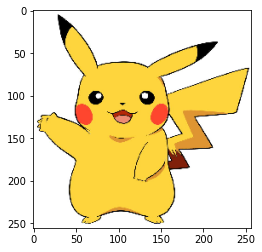

In [32]:
test_image = image.load_img('C:/Users/John/Documents/ml_projects/pokemon-classifier/output_folder/test/pikachu/Pikachu6.jpg', target_size=(256,256))
plt.imshow(test_image)
plt.show()

In [ ]:
true_list = []
prediction_list = []
for i in os.listdir(data_dir):
  for starter in os.listdir(os.path.join(data_dir, folder)):
    img = image.load_img(os.path.join(data_dir, folder, image), target_size=(256,256))
    plt.imshow(img)
    plt.show()
    true_list.append(i)

    X = image.img_to_array(img)
    X = np.expand_dims(X, axis=0)
    images = np.vstack([X])
    predictions = model.predict(images).argmax(1)
    prediction_list.append(predictions)
    if predictions == 0:
      pokemon = 'bulbasaur'
    if predictions == 1:
      pokemon = 'charmander'
    if predictions == 2:
      pokemon = 'pikachu'
    if predictions == 3:
      pokemon = 'squirtle'
    print('predict: ', pokemon)
    print('true: ', i)

for i in range(len(true_list)):
  if true_list[i] == 'Squirtle':
    true_list[i] = 3
  if true_list[i] == 'Bulbasaur':
    true_list[i] = 0
  if true_list[i] == 'Charmander':
    true_list[i] = 1
  if true_list[i] == 'Pikachu':
    true_list[i] = 2

In [33]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [ ]:
p_test = model.predict(images).argmax(axis=1)
cm = confusion_matrix(true_list, prediction_list)
plot_confusion_matrix(cm, list(range(4)))